- PyTorch の画像分類の事前学習済みモデルはすべて224*224画素の画像で学習済

# ファインチューニングと転移学習
- ファインチューニングは、学習済モデルのパラメタを初期値として利用するが、すべてのレイヤーで再学習する
    - 学習データが大量にある場合に向いている → CIFAR10は5万件もあるので本章ではファインチューニングを用いる
- 転移学習は、学習済モデルのパラメタのうち、入力に近い部分は固定し、出力に近い部分のみ学習する
    - 学習データが少ない場合に向いている

In [1]:
# 必要ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [2]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# 著者の共通関数読み込み
import sys
sys.path.append("../../lib/")
from pythonlibs.torch_lib1 import *

# 11.4 nn.AdaptiveAvgPool2d

- AdaptiveXXXPool2d で指定するパラメタは、変換後の画素数
- 集約化の方法はXXXで決まる

In [6]:
p = nn.AdaptiveAvgPool2d((1, 1))
print(p)

l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [7]:
# 事前学習済みモデルのシミュレーション
# 100枚 * 32チャネル * 16画素 * 16画素
inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0], -1)
m3 = l1(m2)

# チャネルごとに平均値の1画素のみとなる
print(m1.shape)
# 画像ごとに一次元ベクトル化
print(m2.shape)
print(m3.shape)

torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


- この仕組みで、inputsのshapeが[100, 32, 8, 8]でも[100, 32, 4, 4]でも、同じ線形関数 Linear(32, 10) で受け取れる

In [8]:
# 分類先クラス名の定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(classes)

In [10]:
# transforms の定義
# 学習データ用
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.33),
        ratio=(0.3, 3.3),
        value=0,
        inplace=False,
    ),
])

# 検証データ用: 正規化のみ
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
])

In [11]:
# データ取得用関数 Dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print(len(train_set))
print(len(test_set))
print(type(train_set[0]))
tensor1_1 = train_set[0][0]
label1 = train_set[0][1]
print(tensor1_1.size())
print(label1)

50000
10000
<class 'tuple'>
torch.Size([3, 112, 112])
6


In [20]:
# バッチサイズ指定
batch_size = 50

# データローダー

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
) 

In [21]:
# 事前学習済みモデルロード
# pretraind で学習済パラメタを読み込む
from torchvision import models
net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ykite/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.5MB/s]


In [22]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
net = net.to(device)
summary(net, (100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 1000]               --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [24]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


# 11.7 最終レイヤーの付け替え
- ファインチューニングの場合も、転移学習の場合も、学習済モデルの最終段を目的にあった線形関数に付け替える必要がある

In [25]:
torch_seed()

fc_in_features = net.fc.in_features
# 付け替え
net.fc = nn.Linear(fc_in_features, n_output)

In [27]:
net = net.to(device)

In [28]:
# 損失の計算グラフ可視化

# criterion = nn.CrossEntropyLoss()
# loss = eval_loss(test_loader, device, net, criterion)
# g = make_dot(loss, params=dict(net.named_parameters()))
# display(g)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [29]:
torch_seed()

# 事前学習済みモデルのロード
# pretraind = True で学習済みパラメータも一緒に読み込む
net = models.resnet18(pretrained=True)

# 最終レイヤー関数の入力次元数を確認
fc_in_features = net.fc.in_features

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(fc_in_features, n_output)

net = net.to(device)

lr = 0.01
criterion = nn.CrossEntropyLoss()
# 事前学習済みモデルを利用する場合、シンプルな最適化関数が望ましい -> Adam ではなく SGD with momentum を使用
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))

In [30]:
# 学習
num_epochs = 5
history = fit(
    net,
    optimizer,
    criterion,
    num_epochs, 
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.72185 acc: 0.76112 val_loss: 0.46871, val_acc: 0.85440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.41016 acc: 0.86118 val_loss: 0.33782, val_acc: 0.89040


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.32798 acc: 0.88662 val_loss: 0.27671, val_acc: 0.90880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.26867 acc: 0.90818 val_loss: 0.28011, val_acc: 0.90670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.23105 acc: 0.91976 val_loss: 0.23993, val_acc: 0.92050


初期状態: 損失: 0.46871 精度: 0.85440
最終状態: 損失: 0.23993 精度: 0.92050


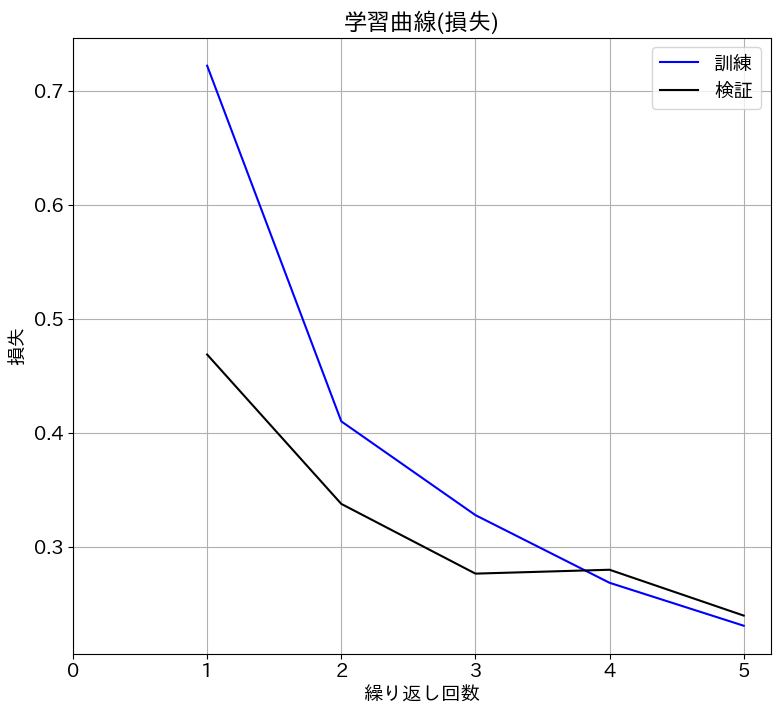

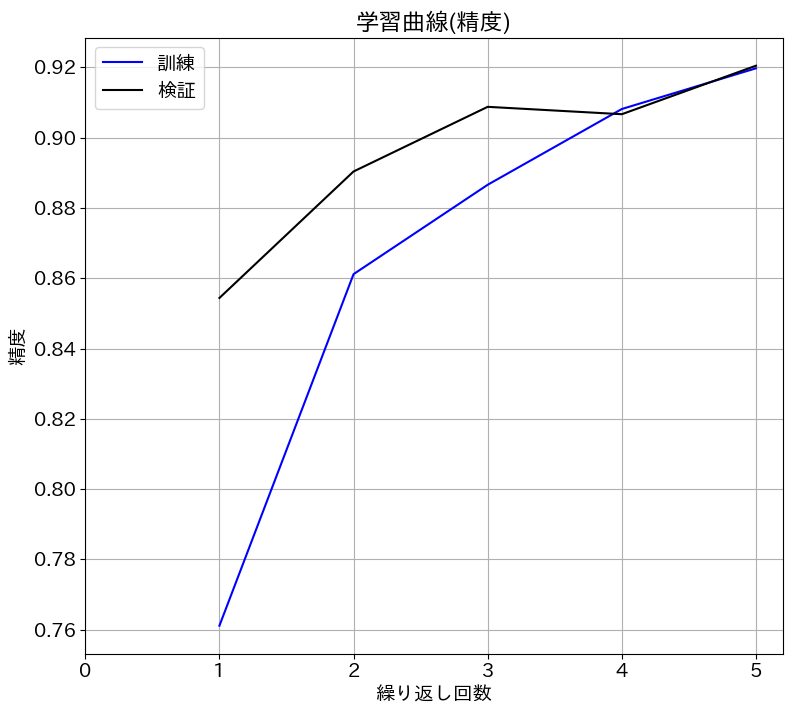

In [31]:
evaluate_history(history)

# 11.9 VGG-19-BNの利用

In [32]:
from torchvision import models
net = models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\ykite/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:50<00:00, 11.3MB/s] 


In [33]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [34]:
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [35]:
torch_seed()

# 事前学習済みモデルの読み込み
net = models.vgg19_bn(pretrained = True)

# 最終レイヤー関数の付け替え
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# 以下、再現性およびONNX形式のエクスポート対応
# features最後のMaxPool2dをはずす
net.features = net.features[:-1]
# AdaptiveAvgPool2dをはずす
net.avgpool = nn.Identity()

net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))

In [36]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.49696 acc: 0.83186 val_loss: 0.18506, val_acc: 0.93660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.23814 acc: 0.91960 val_loss: 0.15410, val_acc: 0.94620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.18257 acc: 0.93712 val_loss: 0.13118, val_acc: 0.95490


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.15174 acc: 0.94852 val_loss: 0.12499, val_acc: 0.95850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.13258 acc: 0.95498 val_loss: 0.12474, val_acc: 0.95760


初期状態: 損失: 0.18506 精度: 0.93660
最終状態: 損失: 0.12474 精度: 0.95760


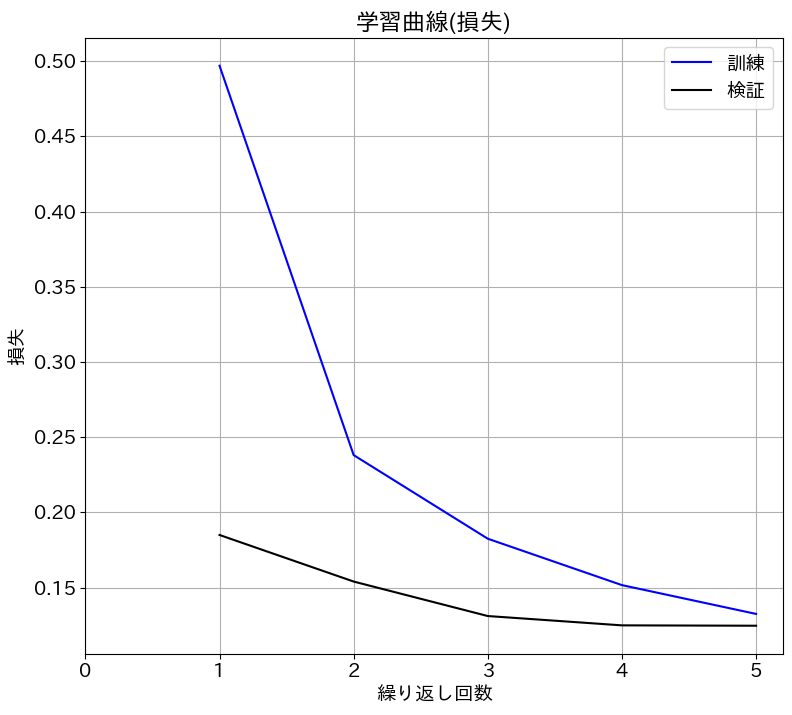

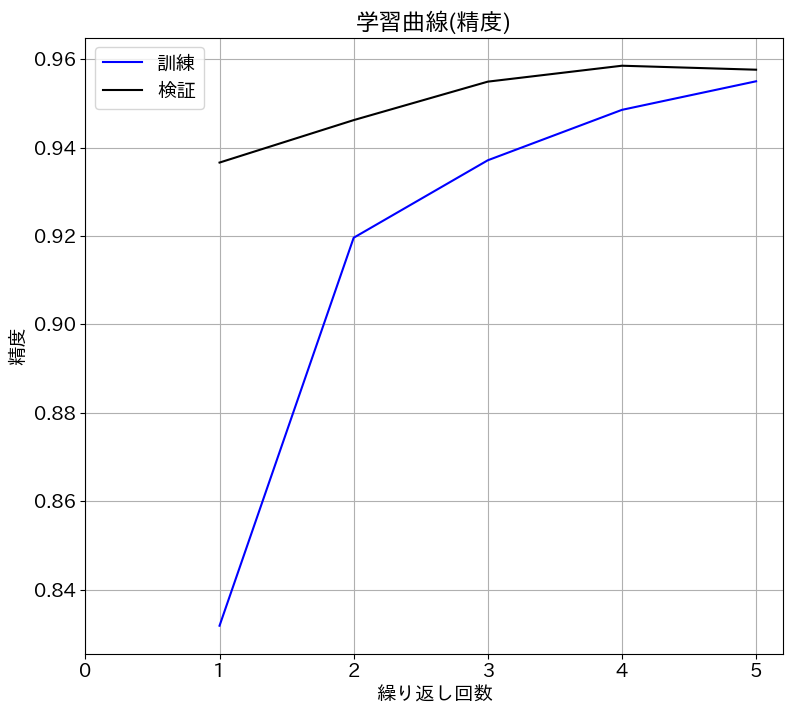

In [37]:
evaluate_history(history)

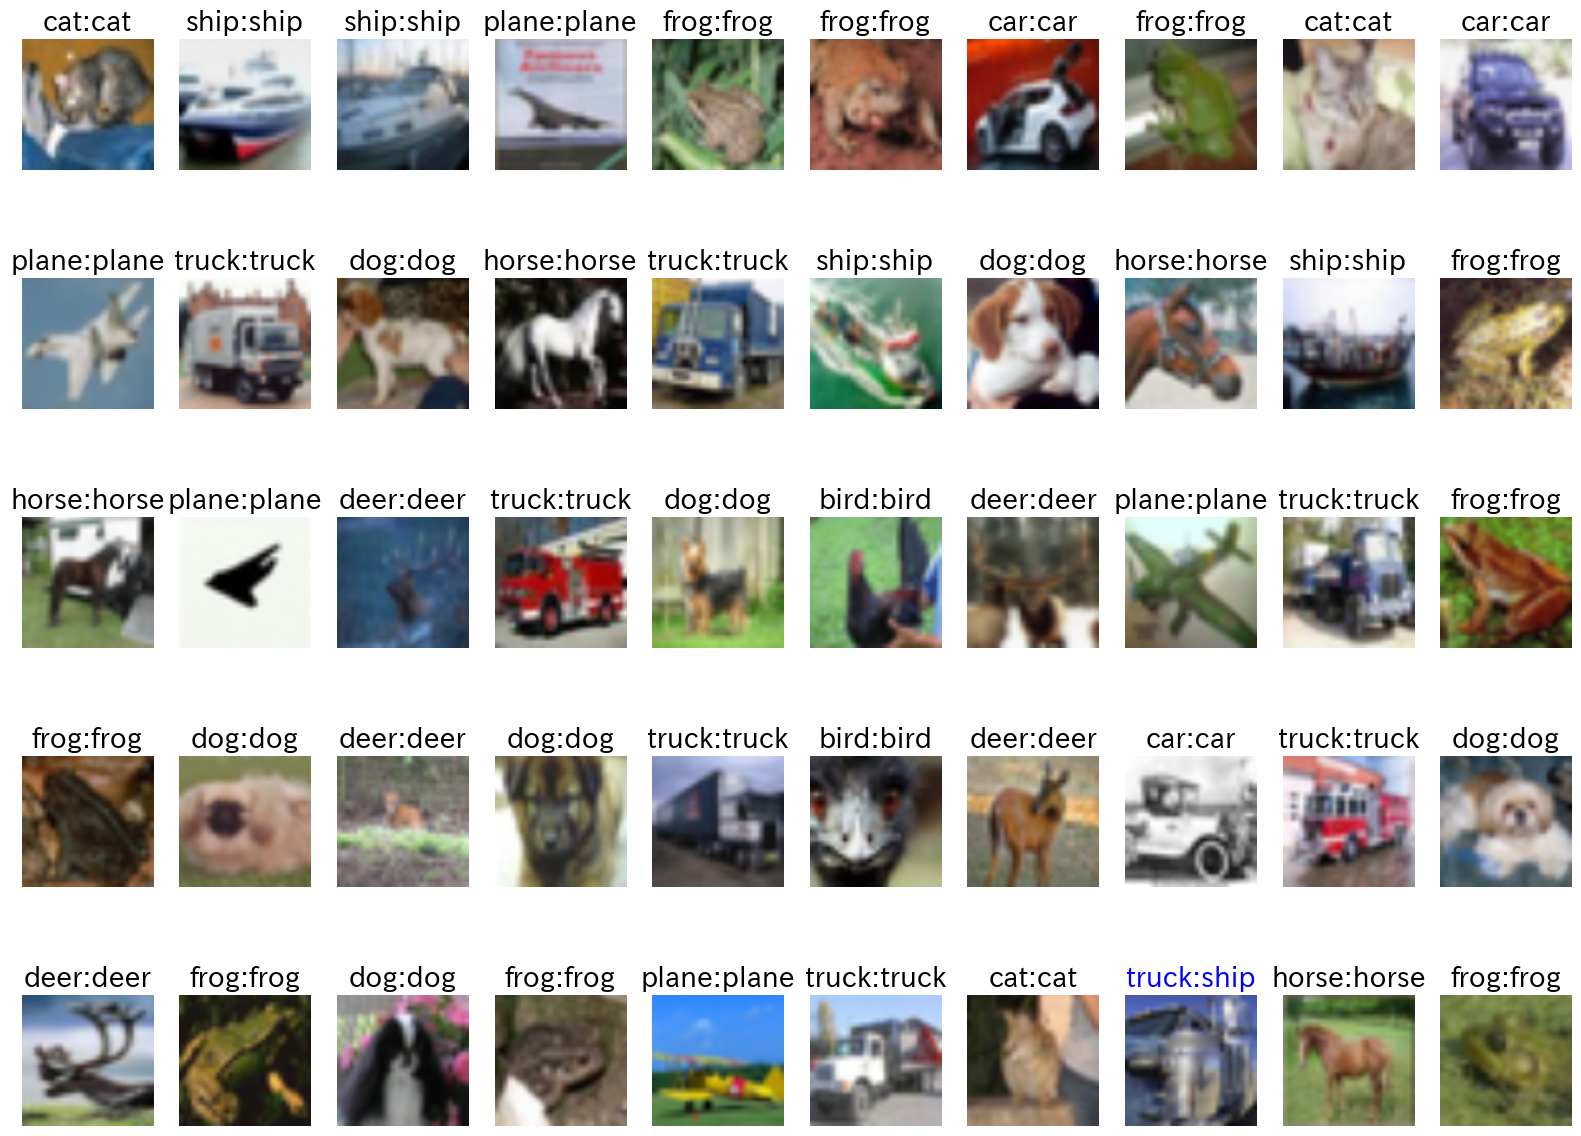

In [38]:
show_images_labels(test_loader, classes, net, device)